# ML match for LOFAR and the Legacy-WISE catalogue: Source catalogue

This version computes the final parameters for the 0h region in an iterative fashion. The computation of the $Q_0$ is also included here.

## Configuration

### Load libraries and setup

In [63]:
import pickle
import os
import sys
from glob import glob
from shutil import copyfile
import numpy as np
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord, search_around_sky
from IPython.display import clear_output

In [2]:
try:
    BASEPATH = os.path.dirname(os.path.realpath(__file__))
    data_path = os.path.join(BASEPATH, "..", "..", "data")
except NameError:
    if os.path.exists("data"):
        BASEPATH = "."
        data_path = os.path.join(BASEPATH, "data")
    else:
        BASEPATH = os.getcwd()
        data_path = os.path.join(BASEPATH, "..", "..", "data")

In [49]:
sys.path.append(os.path.join(BASEPATH, '..', '..', 'src'))
from mltier1 import (get_center, get_n_m, estimate_q_m, Field, SingleMLEstimator, MultiMLEstimator,
                     parallel_process, get_sigma_all, get_q_m, get_threshold, q0_min_level, q0_min_numbers,
                     get_n_m_kde, estimate_q_m_kde, get_q_m_kde, describe, Q_0)

In [4]:
%load_ext autoreload

In [5]:
%autoreload

In [6]:
import matplotlib.pyplot as plt

In [7]:
%matplotlib inline

### General configuration

In [8]:
save_intermediate = True
plot_intermediate = True

In [9]:
idp = os.path.join(BASEPATH, "..", "..", "data", "idata", "params")

In [10]:
if not os.path.isdir(idp):
    os.makedirs(idp)

### Area limits

In [11]:
# Test samples LoTSS_DR2_DUMMYCAT_FORPEPE_0h.srl.fits
dec_down = 22.25
dec_up = 32.
ra_down = 0.
ra_up = 20.5

In [64]:
margin_ra = 0.1
margin_dec = 0.1

In [65]:
field = Field(ra_down, ra_up, dec_down, dec_up)

In [66]:
field_full = field
#field_full = Field(160.0, 232.0, 42.0, 62.0)

In [67]:
field_optical = Field(
    ra_down - margin_ra, 
    ra_up + margin_ra, 
    dec_down - margin_dec, 
    dec_up + margin_dec)

## Load data

In [14]:
combined_all = Table.read(os.path.join(data_path, "samples", "test_combined.fits"))

We will start to use the updated catalogues that include the output of the LOFAR Galaxy Zoo work.

In [15]:
#lofar_all = Table.read("data/LOFAR_HBA_T1_DR1_catalog_v0.9.srl.fits")
#lofar_all = Table.read(os.path.join(data_path, "samples", "P005p28.fits"))
#lofar_all = Table.read(os.path.join(data_path, "samples", "LoTSS_DR2_RA0INNER_v0.9.srl.fits"))
lofar_all = Table.read(os.path.join(data_path, "samples", "LoTSS_DR2_DUMMYCAT_FORPEPE_0h.srl.fits"))

In [16]:
np.array(combined_all.colnames)

array(['RA', 'DEC', 'UID_L', 'UNWISE_OBJID', 'MAG_R', 'MAG_W1', 'MAG_W2'],
      dtype='<U12')

In [17]:
np.array(lofar_all.colnames)

array(['Source_Name', 'RA', 'E_RA', 'DEC', 'E_DEC', 'Peak_flux',
       'E_Peak_flux', 'Total_flux', 'E_Total_flux', 'Maj', 'E_Maj', 'Min',
       'E_Min', 'DC_Maj', 'E_DC_Maj', 'DC_Min', 'E_DC_Min', 'PA', 'E_PA',
       'DC_PA', 'E_DC_PA', 'Isl_rms', 'S_Code', 'Mosaic_ID'], dtype='<U12')

In [18]:
describe(lofar_all['Maj'])

10.518 +/- 7.715; median: 8.260; limits: [3.790, 436.840]; N=516404 (0 NaN; 0 masked)


### Filter catalogues

We will take the sources in the main region but also discard sources with a Major axis size bigger than 30 arsecs.

In [19]:
max_major = 30

In [20]:
lofar_aux = lofar_all[~np.isnan(lofar_all['Maj'])]

In [21]:
lofar = field.filter_catalogue(lofar_aux[(lofar_aux['Maj'] < max_major)], 
                               colnames=("RA", "DEC"))

In [22]:
lofar_full = field_full.filter_catalogue(lofar_aux[(lofar_aux['Maj'] < max_major)], 
                                         colnames=("RA", "DEC"))

In [70]:
combined = field_optical.filter_catalogue(combined_all, 
                                colnames=("RA", "DEC"))

In [69]:
combined_nomargin = field.filter_catalogue(combined_all, 
                                colnames=("RA", "DEC"))

### Additional data

Compute some additional data that was not available in the catalogues like the colour or an auxiliary array with an index.

In [78]:
combined["colour"] = combined["MAG_R"] - combined["MAG_W1"]

In [79]:
combined_aux_index = np.arange(len(combined))

### Sky coordinates

In [71]:
coords_combined = SkyCoord(combined['RA'], 
                           combined['DEC'], 
                           unit=(u.deg, u.deg), 
                           frame='icrs')

In [72]:
coords_lofar = SkyCoord(lofar['RA'], 
                       lofar['DEC'], 
                       unit=(u.deg, u.deg), 
                       frame='icrs')

### Class of sources in the combined catalogue

The sources are grouped depending on the available photometric data.

In [73]:
combined_legacy = (
    ~np.isnan(combined["MAG_R"]) & 
    ~np.isnan(combined["MAG_W1"]) & 
    ~np.isnan(combined["MAG_W2"])
)

In [74]:
combined_wise =(
    np.isnan(combined["MAG_R"]) & 
    ~np.isnan(combined["MAG_W1"])
)

In [75]:
combined_wise2 =(
    np.isnan(combined["MAG_R"]) & 
    np.isnan(combined["MAG_W1"])
)

In [76]:
print("Total     - ", len(combined))
print("R and W1  - ", np.sum(combined_legacy))
print("Only WISE - ", np.sum(combined_wise))
print("Only W2   - ", np.sum(combined_wise2))

Total     -  14510713
R and W1  -  12790855
Only WISE -  1516793
Only W2   -  203065


### Colour categories

The colour categories will be used after the first ML match

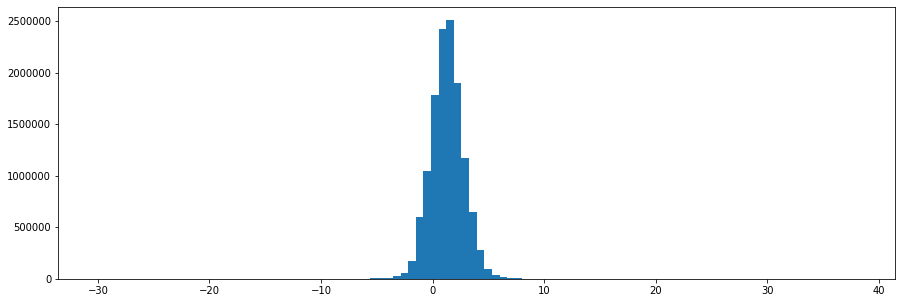

In [80]:
plt.hist(combined["colour"], bins=100);

In [81]:
#from astroML.plotting import hist as amlhist
from astropy.visualization import hist as amlhist

In [82]:
list(range(10,100,10))

[10, 20, 30, 40, 50, 60, 70, 80, 90]

In [83]:
np.round(np.percentile(combined["colour"][~np.isnan(combined["colour"])], list(range(10,100,10))), 1)

array([-0.5,  0.1,  0.6,  1. ,  1.3,  1.6,  2. ,  2.5,  3.1])

In [84]:
#colour_limits = [0.0, 0.5, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.5, 4.0]
colour_limits = np.round(np.percentile(combined["colour"][~np.isnan(combined["colour"])], list(range(10,100,10))), 1)

In [85]:
# Start with the W2-only, W1-only, and "less than lower colour" bins
colour_bin_def = [{"name":"only W2", "condition": combined_wise2},
                  {"name":"only WISE", "condition": combined_wise},
                  {"name":"-inf to {}".format(colour_limits[0]), 
                   "condition": (combined["colour"] < colour_limits[0])}]

# Get the colour bins
for i in range(len(colour_limits)-1):
    name = "{} to {}".format(colour_limits[i], colour_limits[i+1])
    condition = ((combined["colour"] >= colour_limits[i]) & 
                 (combined["colour"] < colour_limits[i+1]))
    colour_bin_def.append({"name":name, "condition":condition})

# Add the "more than higher colour" bin
colour_bin_def.append({"name":"{} to inf".format(colour_limits[-1]), 
                       "condition": (combined["colour"] >= colour_limits[-1])})

The dictionary ''colour_bin_def'' contains the indices of the different colour categories.

In [86]:
colour_bin_def

[{'name': 'only W2',
  'condition': array([False, False, False, ...,  True,  True,  True])},
 {'name': 'only WISE',
  'condition': array([False, False, False, ..., False, False, False])},
 {'name': '-inf to -0.5',
  'condition': array([ True, False, False, ..., False, False, False])},
 {'name': '-0.5 to 0.1',
  'condition': array([False, False, False, ..., False, False, False])},
 {'name': '0.1 to 0.6',
  'condition': array([False, False, False, ..., False, False, False])},
 {'name': '0.6 to 1.0',
  'condition': array([False, False, False, ..., False, False, False])},
 {'name': '1.0 to 1.3',
  'condition': array([False, False,  True, ..., False, False, False])},
 {'name': '1.3 to 1.6',
  'condition': array([False, False, False, ..., False, False, False])},
 {'name': '1.6 to 2.0',
  'condition': array([False, False, False, ..., False, False, False])},
 {'name': '2.0 to 2.5',
  'condition': array([False, False, False, ..., False, False, False])},
 {'name': '2.5 to 3.1',
  'condition': ar

A colour category variable (numerical index from 0 to 11) is assigned to each row

In [87]:
combined["category"] = np.nan
for i in range(len(colour_bin_def)):
    combined["category"][colour_bin_def[i]["condition"]] = i

We check that there are no rows withot a category assigned

In [88]:
np.sum(np.isnan(combined["category"]))

0

We get the number of sources of the combined catalogue in each colour category. It will be used at a later stage to compute the $Q_0$ values

In [89]:
numbers_combined_bins = np.array([np.sum(a["condition"]) for a in colour_bin_def])

In [90]:
numbers_combined_bins

array([ 203065, 1516793, 1285276, 1163363, 1419867, 1392164, 1134808,
       1139112, 1392687, 1398193, 1143177, 1322208])

In [91]:
np.sum(numbers_combined_bins)

14510713

## Description

### Sky coverage

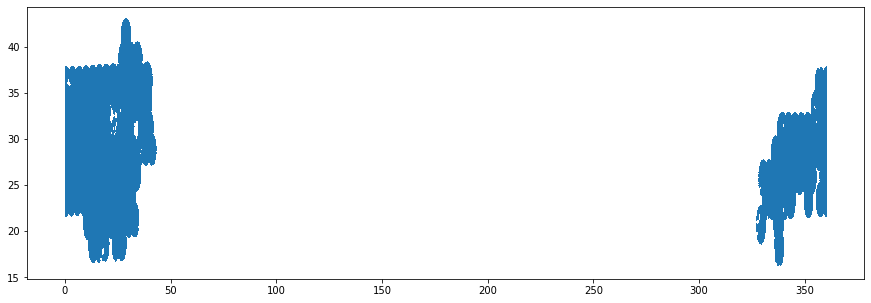

In [92]:
plt.rcParams["figure.figsize"] = (15,5)
plt.plot(lofar_all["RA"],
     lofar_all["DEC"],
     ls="", marker=",");

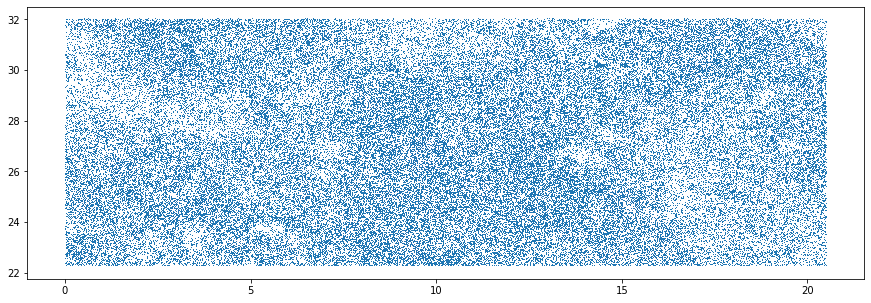

In [93]:
plt.rcParams["figure.figsize"] = (15,5)
plt.plot(lofar_full["RA"],
     lofar_full["DEC"],
     ls="", marker=",");

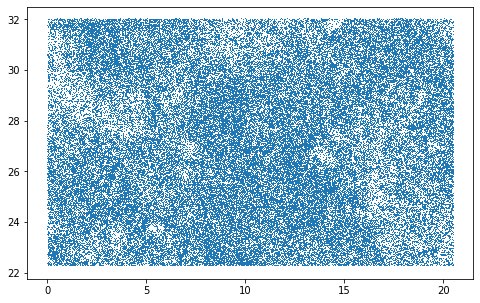

In [94]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(lofar["RA"],
     lofar["DEC"],
     ls="", marker=",");

In [95]:
len(lofar)

100207

### Summary of galaxy types in the combined catalogue

In [96]:
np.sum(combined_legacy) # Matches

12790855

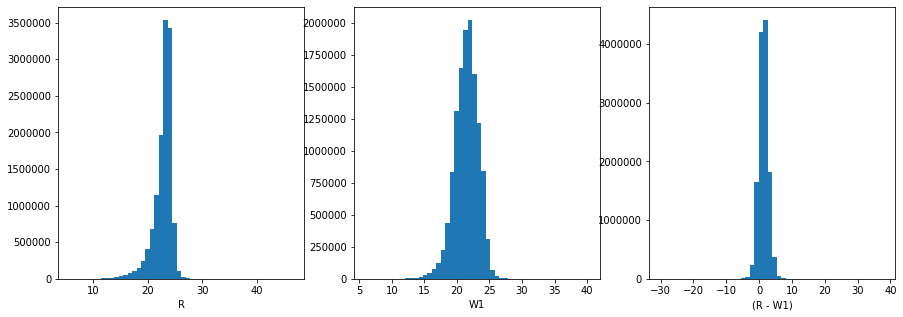

In [97]:
plt.rcParams["figure.figsize"] = (15,5)
plt.subplot(1,3,1)
plt.hist(combined["MAG_R"][combined_legacy], bins=50)
plt.xlabel("R")
plt.subplot(1,3,2)
plt.hist(combined["MAG_W1"][combined_legacy], bins=50)
plt.xlabel("W1")
plt.subplot(1,3,3)
plt.hist((combined["MAG_R"] - combined["MAG_W1"])[combined_legacy], bins=50)
plt.xlabel("(R - W1)");

In [98]:
np.sum(combined_wise) # Only WISE

1516793

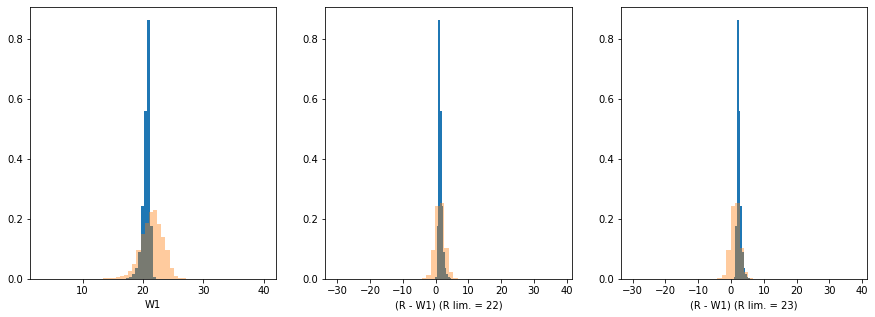

In [99]:
plt.rcParams["figure.figsize"] = (15,5)
plt.subplot(1,3,1)
plt.hist(combined["MAG_W1"][combined_wise], bins=50, density=True)
plt.hist(combined["MAG_W1"][combined_legacy], bins=50, alpha=0.4, density=True)
plt.xlabel("W1")
plt.subplot(1,3,2)
plt.hist((22 - combined["MAG_W1"])[combined_wise], bins=50, density=True)
plt.hist((combined["MAG_R"] - combined["MAG_W1"])[combined_legacy], bins=50, alpha=0.4, density=True)
plt.xlabel("(R - W1) (R lim. = 22)")
plt.subplot(1,3,3)
plt.hist((23 - combined["MAG_W1"])[combined_wise], bins=50, density=True)
plt.hist((combined["MAG_R"] - combined["MAG_W1"])[combined_legacy], bins=50, alpha=0.4, density=True)
plt.xlabel("(R - W1) (R lim. = 23)");

In [100]:
np.sum(combined_wise2) # Only W2

203065

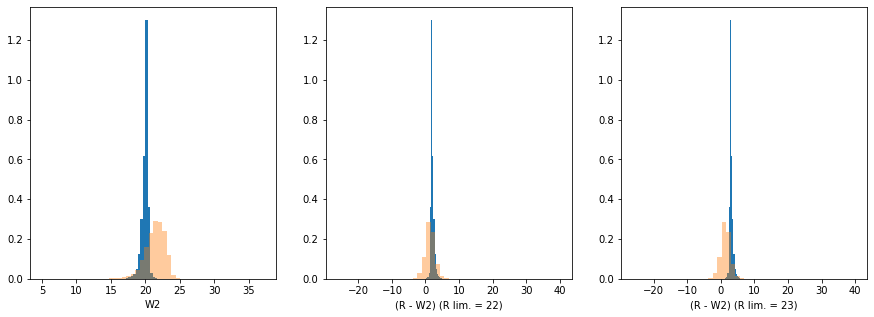

In [101]:
plt.rcParams["figure.figsize"] = (15,5)
plt.subplot(1,3,1)
plt.hist(combined["MAG_W2"][combined_wise2], bins=50, density=True)
plt.hist(combined["MAG_W2"][combined_legacy], bins=50, alpha=0.4, density=True)
plt.xlabel("W2")
plt.subplot(1,3,2)
plt.hist((22 - combined["MAG_W2"])[combined_wise2], bins=50, density=True)
plt.hist((combined["MAG_R"] - combined["MAG_W2"])[combined_legacy], bins=50, alpha=0.4, density=True)
plt.xlabel("(R - W2) (R lim. = 22)")
plt.subplot(1,3,3)
plt.hist((23 - combined["MAG_W2"])[combined_wise2], bins=50, density=True)
plt.hist((combined["MAG_R"] - combined["MAG_W2"])[combined_legacy], bins=50, alpha=0.4, density=True)
plt.xlabel("(R - W2) (R lim. = 23)");

## Maximum Likelihood 1st iteration

### First estimation of $Q_0$ for r-band

In [102]:
n_iter = 10

In [103]:
rads = list(range(1,26))

In [104]:
q_0_comp_r = Q_0(coords_lofar, coords_combined[combined_legacy], field)

In [105]:
q_0_rad_r = []
q_0_rad_r_std = []
for radius in rads:
    q_0_rad_aux = []
    for i in range(n_iter):
        try:
            out = q_0_comp_r(radius=radius)
        except ZeroDivisionError:
            continue
        else:
            q_0_rad_aux.append(out)
    q_0_rad_r.append(np.mean(q_0_rad_aux))
    q_0_rad_r_std.append(np.std(q_0_rad_aux))
    print(
        "{:2d} {:7.5f} +/- {:7.5f} [{:7.5f} {:7.5f}]".format(
            radius,
            np.mean(q_0_rad_aux),
            np.std(q_0_rad_aux),
            np.min(q_0_rad_aux),
            np.max(q_0_rad_aux),
        )
    )

 1 0.43409 +/- 0.00016 [0.43381 0.43438]
 2 0.59422 +/- 0.00026 [0.59391 0.59475]
 3 0.64525 +/- 0.00025 [0.64484 0.64565]
 4 0.67243 +/- 0.00073 [0.67124 0.67358]
 5 0.68711 +/- 0.00059 [0.68602 0.68782]
 6 0.69608 +/- 0.00106 [0.69415 0.69767]
 7 0.70400 +/- 0.00087 [0.70276 0.70541]
 8 0.71064 +/- 0.00129 [0.70831 0.71212]
 9 0.71415 +/- 0.00138 [0.71205 0.71548]
10 0.71927 +/- 0.00251 [0.71406 0.72220]
11 0.72366 +/- 0.00300 [0.72000 0.72891]
12 0.72785 +/- 0.00287 [0.72421 0.73485]
13 0.72794 +/- 0.00362 [0.72227 0.73258]
14 0.73075 +/- 0.00434 [0.72472 0.73624]
15 0.73217 +/- 0.00421 [0.72373 0.73811]
16 0.72379 +/- 0.00545 [0.71713 0.73056]
17 0.71886 +/- 0.00521 [0.70660 0.72736]
18 0.71779 +/- 0.01015 [0.69894 0.73364]
19 0.73093 +/- 0.01260 [0.70482 0.75064]
20 0.69267 +/- 0.02585 [0.64835 0.73109]
21 0.71307 +/- 0.02773 [0.64286 0.74638]
22 0.66498 +/- 0.04483 [0.60000 0.74468]
23 0.52702 +/- 0.06805 [0.43750 0.65385]
24 0.45345 +/- 0.12141 [0.23529 0.61765]
25 0.67085 +/- 0

(0, 1)

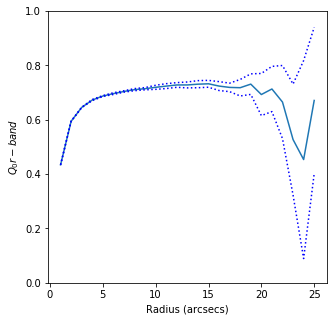

In [106]:
plt.rcParams["figure.figsize"] = (5, 5)
plt.plot(rads, q_0_rad_r)
plt.plot(rads, np.array(q_0_rad_r) + 3 * np.array(q_0_rad_r_std), ls=":", color="b")
plt.plot(rads, np.array(q_0_rad_r) - 3 * np.array(q_0_rad_r_std), ls=":", color="b")
plt.xlabel("Radius (arcsecs)")
plt.ylabel("$Q_0 r-band$")
plt.ylim([0, 1])

In [107]:
Q0_r = q_0_rad_r[4]

In [108]:
print(Q0_r)

0.6871134546334241


### Compute q(m) and n(m)

#### R-band preparation

In [109]:
bandwidth_r = 0.5

In [110]:
catalogue_r = combined[combined_legacy]

In [111]:
bin_list_r = np.linspace(11.5, 29.5, 361) # Bins of 0.05

In [112]:
center_r = get_center(bin_list_r)

In [113]:
n_m_r = get_n_m_kde(catalogue_r["MAG_R"], center_r, field.area, bandwidth=bandwidth_r)

In [114]:
n_m_r_cs = np.cumsum(n_m_r)

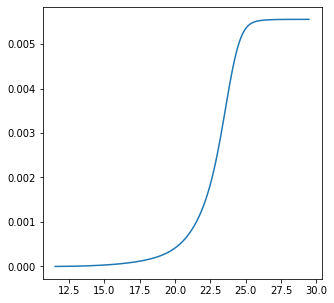

In [115]:
plt.rcParams["figure.figsize"] = (5,5)
plt.plot(center_r, n_m_r_cs);

In [116]:
q_m_r = estimate_q_m_kde(catalogue_r["MAG_R"], 
                      center_r, 
                      n_m_r, 
                      coords_lofar, 
                      coords_combined[combined_legacy], 
                      radius=5, 
                      bandwidth=bandwidth_r)

In [117]:
q_m_r_cs = np.cumsum(q_m_r)

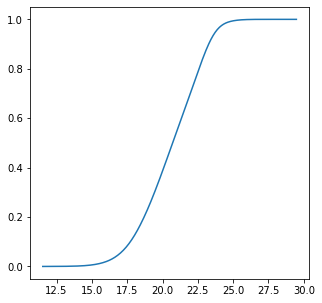

In [118]:
plt.rcParams["figure.figsize"] = (5,5)
plt.plot(center_r, q_m_r_cs);

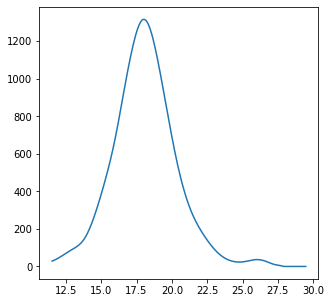

In [119]:
plt.rcParams["figure.figsize"] = (5,5)
plt.plot(center_r, q_m_r/n_m_r);

#### W1-band preparation

In [120]:
bandwidth_w1 = 0.5

In [121]:
catalogue_w1 = combined[combined_wise]

In [122]:
bin_list_w1 = np.linspace(11.5, 29.5, 361) # Bins of 0.05

In [123]:
center_w1 = get_center(bin_list_w1)

In [124]:
n_m_w1 = get_n_m_kde(catalogue_w1["MAG_W1"], center_w1, field.area, bandwidth=bandwidth_w1)

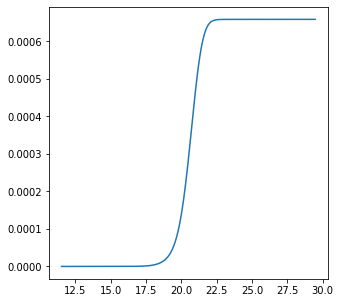

In [125]:
plt.rcParams["figure.figsize"] = (5,5)
plt.plot(center_w1, np.cumsum(n_m_w1));

In [126]:
q_m_w1 = estimate_q_m_kde(catalogue_w1["MAG_W1"], 
                      center_w1, 
                      n_m_w1, coords_lofar, 
                      coords_combined[combined_wise], 
                      radius=5, 
                      bandwidth=bandwidth_w1)

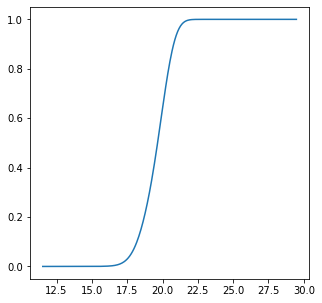

In [127]:
plt.plot(center_w1, np.cumsum(q_m_w1));

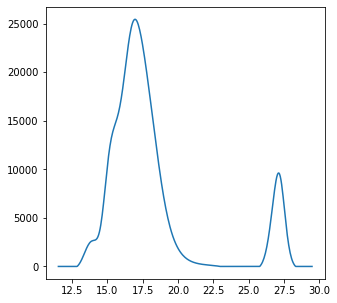

In [128]:
plt.plot(center_w1, q_m_w1/n_m_w1);

#### W2-band preparation

In [129]:
bandwidth_w2 = 0.5

In [130]:
catalogue_w2 = combined[combined_wise2]

In [131]:
bin_list_w2 = np.linspace(12., 22., 181) # Bins of 0.05

In [132]:
center_w2 = get_center(bin_list_w2)

In [134]:
n_m_w2 = get_n_m_kde(catalogue_w2["MAG_W2"], center_w2, field.area, bandwidth=bandwidth_w2)

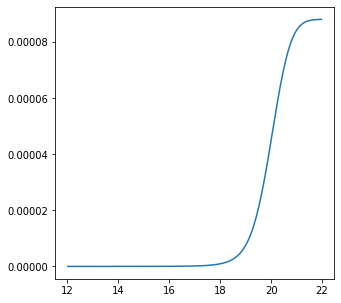

In [135]:
plt.rcParams["figure.figsize"] = (5,5)
plt.plot(center_w2, np.cumsum(n_m_w2));

In [136]:
q_m_w2 = estimate_q_m_kde(catalogue_w2["MAG_W2"], 
                      center_w2, 
                      n_m_w2, coords_lofar, 
                      coords_combined[combined_wise2], 
                      radius=5, 
                      bandwidth=bandwidth_w2)

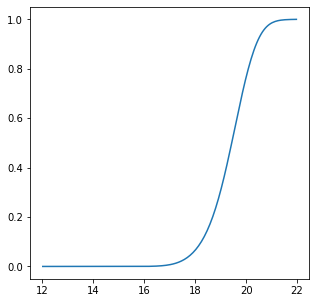

In [137]:
plt.plot(center_w2, np.cumsum(q_m_w2));

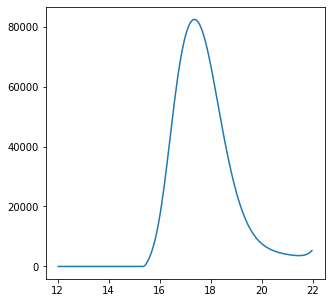

In [138]:
plt.plot(center_w2, q_m_w2/n_m_w2);

### r-band match

#### $Q_0$ and likelihood estimator

In [139]:
# # Initial test
# Q0_r = 0.65
# Q0_w1 = 0.237
# Q0_w2 = 0.035

In [140]:
likelihood_ratio_r = SingleMLEstimator(Q0_r, n_m_r, q_m_r, center_r)

We will get the number of CPUs to use in parallel in the computations

In [141]:
import multiprocessing

In [142]:
n_cpus_total = multiprocessing.cpu_count()

In [143]:
n_cpus = max(1, n_cpus_total-1)

In [144]:
print(n_cpus)

7


Get the possible matches up to a radius of 15 arcseconds in this first step 

In [145]:
radius = 15

In [146]:
idx_lofar, idx_i, d2d, d3d = search_around_sky(
    coords_lofar, coords_combined[combined_legacy], radius*u.arcsec)

In [147]:
idx_lofar_unique = np.unique(idx_lofar)

In [148]:
lofar["lr_r"] = np.nan                   # Likelihood ratio
lofar["lr_dist_r"] = np.nan              # Distance to the selected source
lofar["lr_index_r"] = np.nan             # Index of the PanSTARRS source in combined

In [149]:
total_sources = len(idx_lofar_unique)
combined_aux_index = np.arange(len(combined))

In [150]:
def ml(i):
    idx_0 = idx_i[idx_lofar == i]
    d2d_0 = d2d[idx_lofar == i]
    mag = catalogue_r["MAG_R"][idx_0]
    
    lofar_ra = lofar[i]["RA"]
    lofar_dec = lofar[i]["DEC"]
    lofar_pa = lofar[i]["PA"]
    lofar_maj_err = lofar[i]["E_Maj"]
    lofar_min_err = lofar[i]["E_Min"]
    c_ra = catalogue_r["RA"][idx_0]
    c_dec = catalogue_r["DEC"][idx_0]
    c_ra_err = np.ones_like(c_ra)*0.6/3600.
    c_dec_err = np.ones_like(c_ra)*0.6/3600.
    
    sigma_0_0, det_sigma = get_sigma_all(lofar_maj_err, lofar_min_err, lofar_pa, 
                      lofar_ra, lofar_dec, 
                      c_ra, c_dec, c_ra_err, c_dec_err)
    
    lr_0 = likelihood_ratio_r(mag, d2d_0.arcsec, sigma_0_0, det_sigma)
    chosen_index = np.argmax(lr_0)
    result = [combined_aux_index[combined_legacy][idx_0[chosen_index]], # Index
              (d2d_0.arcsec)[chosen_index],                        # distance
              lr_0[chosen_index]]                                  # LR
    return result

In [151]:
from joblib import Parallel, delayed
from tqdm import tqdm, tqdm_notebook

In [ ]:
res = Parallel(n_jobs=n_cpus)(delayed(ml)(i) for i in tqdm_notebook(idx_lofar_unique))

In [154]:
# # Old version using concurrent futures
# res = parallel_process(idx_lofar_unique, ml, n_jobs=n_cpus)

In [155]:
(lofar["lr_index_r"][idx_lofar_unique], 
 lofar["lr_dist_r"][idx_lofar_unique], 
 lofar["lr_r"][idx_lofar_unique]) = list(map(list, zip(*res)))

#### Threshold and selection for r-band

In [156]:
lofar["lr_r"][np.isnan(lofar["lr_r"])] = 0

In [157]:
threshold_r = np.percentile(lofar["lr_r"], 100*(1 - Q0_r))

In [158]:
threshold_r #4.8 before

0.33868299502705423

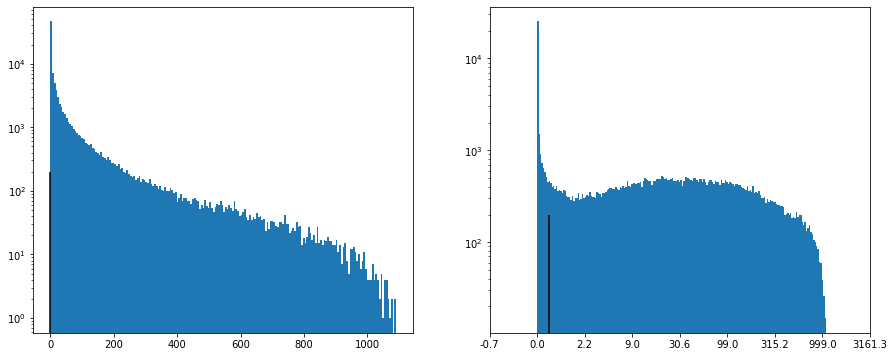

In [159]:
plt.rcParams["figure.figsize"] = (15,6)
ax1 = plt.subplot(1,2,1)
plt.hist(lofar[lofar["lr_r"] != 0]["lr_r"], bins=200)
plt.vlines([threshold_r], 0, 200)
ax1.set_yscale("log", nonposy='clip')
#plt.ylim([0, 200])
ax2 = plt.subplot(1,2,2)
plt.hist(np.log10(lofar[lofar["lr_r"] != 0]["lr_r"]+1), bins=200)
plt.vlines(np.log10(threshold_r+1), 0, 200)
ticks, _ = plt.xticks()
plt.xticks(ticks, ["{:.1f}".format(10**t-1) for t in ticks])
ax2.set_yscale("log", nonposy='clip')
#plt.ylim([0, 200]);

In [160]:
lofar["lr_index_sel_r"] = lofar["lr_index_r"]
lofar["lr_index_sel_r"][lofar["lr_r"] < threshold_r] = np.nan

Save LR for r-band in external file

In [161]:
columns = ["lr_r", "lr_dist_r", "lr_index_r", "lr_index_sel_r"]
np.savez_compressed(os.path.join(idp, "lr_r.npz"), lr_r=lofar[columns])

### W1-band match

We will work with the sample that has not been already cross-matched

In [179]:
subsample_w1 = (lofar["lr_r"] <= threshold_r)

#### Compute the W1 $Q_0$

In [162]:
coords_lofar_alt = coords_lofar[subsample_w1]

In [163]:
q_0_comp_w1 = Q_0(coords_lofar_alt, coords_combined[combined_wise], field)

In [164]:
q_0_rad_w1 = []
q_0_rad_w1_std = []
for radius in rads:
    q_0_rad_aux = []
    for i in range(n_iter):
        out = q_0_comp_w1(radius=radius)
        q_0_rad_aux.append(out)
    q_0_rad_w1.append(np.mean(q_0_rad_aux))
    q_0_rad_w1_std.append(np.std(q_0_rad_aux))
    print(
        "{:2d} {:7.5f} +/- {:7.5f} [{:7.5f} {:7.5f}]".format(
            radius,
            np.mean(q_0_rad_aux),
            np.std(q_0_rad_aux),
            np.min(q_0_rad_aux),
            np.max(q_0_rad_aux),
        )
    )

 1 0.15016 +/- 0.00023 [0.14980 0.15059]
 2 0.28635 +/- 0.00038 [0.28555 0.28695]
 3 0.34790 +/- 0.00031 [0.34739 0.34838]
 4 0.37771 +/- 0.00065 [0.37607 0.37837]
 5 0.39515 +/- 0.00070 [0.39427 0.39634]
 6 0.40581 +/- 0.00097 [0.40405 0.40748]
 7 0.41388 +/- 0.00142 [0.41211 0.41688]
 8 0.41957 +/- 0.00197 [0.41750 0.42268]
 9 0.42368 +/- 0.00100 [0.42239 0.42594]
10 0.42739 +/- 0.00116 [0.42516 0.42854]
11 0.42811 +/- 0.00202 [0.42517 0.43158]
12 0.43204 +/- 0.00147 [0.42873 0.43438]
13 0.43487 +/- 0.00118 [0.43284 0.43778]
14 0.43512 +/- 0.00182 [0.43185 0.43789]
15 0.43647 +/- 0.00255 [0.43194 0.44015]
16 0.43903 +/- 0.00293 [0.43317 0.44337]
17 0.44005 +/- 0.00231 [0.43680 0.44492]
18 0.44047 +/- 0.00209 [0.43692 0.44527]
19 0.44478 +/- 0.00217 [0.44199 0.44889]
20 0.44611 +/- 0.00336 [0.44202 0.45264]
21 0.44576 +/- 0.00407 [0.43826 0.45219]
22 0.44507 +/- 0.00336 [0.43967 0.44867]
23 0.44457 +/- 0.00442 [0.43896 0.45184]
24 0.44541 +/- 0.00211 [0.44170 0.44814]
25 0.44433 +/- 0

In [165]:
q_0_rad_w1 = np.array(q_0_rad_w1)
q_0_rad_w1_std = np.array(q_0_rad_w1_std)

(0, 0.5)

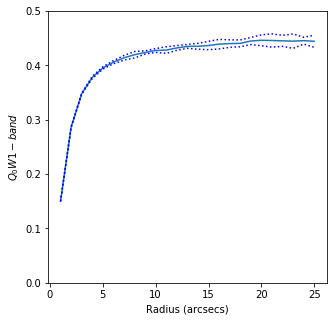

In [168]:
plt.rcParams["figure.figsize"] = (5, 5)
plt.plot(rads, q_0_rad_w1)
plt.plot(rads, q_0_rad_w1 + 3 * q_0_rad_w1_std, ls=":", color="b")
plt.plot(rads, q_0_rad_w1 - 3 * q_0_rad_w1_std, ls=":", color="b")
plt.xlabel("Radius (arcsecs)")
plt.ylabel("$Q_0 W1-band$")
plt.ylim([0, 0.5])

In [169]:
Q0_w1 = q_0_rad_w1[4]

#### Create the likelihood estimator and run

In [180]:
likelihood_ratio_w1 = SingleMLEstimator(Q0_w1, n_m_w1, q_m_w1, center_w1)

In [181]:
idx_lofar, idx_i, d2d, d3d = search_around_sky(
    coords_lofar[subsample_w1], coords_combined[combined_wise], radius*u.arcsec)

In [182]:
idx_lofar_unique = np.unique(idx_lofar)

In [183]:
lofar["lr_w1"] = np.nan                   # Likelihood ratio
lofar["lr_dist_w1"] = np.nan              # Distance to the selected source
lofar["lr_index_w1"] = np.nan             # Index of the PanSTARRS source in combined

In [194]:
def ml_w1(i):
    idx_0 = idx_i[idx_lofar == i]
    d2d_0 = d2d[idx_lofar == i]
    mag = catalogue_w1["MAG_W1"][idx_0]
    
    lofar_ra = lofar[subsample_w1][i]["RA"]
    lofar_dec = lofar[subsample_w1][i]["DEC"]
    lofar_pa = lofar[subsample_w1][i]["PA"]
    lofar_maj_err = lofar[subsample_w1][i]["E_Maj"]
    lofar_min_err = lofar[subsample_w1][i]["E_Min"]
    c_ra = catalogue_w1["RA"][idx_0]
    c_dec = catalogue_w1["DEC"][idx_0]
    c_ra_err = np.ones_like(c_ra)*0.6/3600.
    c_dec_err = np.ones_like(c_ra)*0.6/3600.
    
    sigma_0_0, det_sigma = get_sigma_all(lofar_maj_err, lofar_min_err, lofar_pa, 
                      lofar_ra, lofar_dec, 
                      c_ra, c_dec, c_ra_err, c_dec_err)
    
    lr_0 = likelihood_ratio_w1(mag, d2d_0.arcsec, sigma_0_0, det_sigma)
    chosen_index = np.argmax(lr_0)
    result = [combined_aux_index[combined_wise][idx_0[chosen_index]], # Index
              (d2d_0.arcsec)[chosen_index],                        # distance
              lr_0[chosen_index]]                                  # LR
    return result

In [ ]:
#res = parallel_process(idx_lofar_unique, ml_w1, n_jobs=n_cpus)
res = Parallel(n_jobs=n_cpus)(delayed(ml_w1)(i) for i in tqdm_notebook(idx_lofar_unique))

In [204]:
indices_w1 = np.arange(len(lofar))[subsample_w1][idx_lofar_unique]

In [206]:
(lofar["lr_index_w1"][indices_w1], 
 lofar["lr_dist_w1"][indices_w1], 
 lofar["lr_w1"][indices_w1]) = list(map(list, zip(*res)))

#### Threshold and selection for W1 band

In [207]:
lofar["lr_w1"][np.isnan(lofar["lr_w1"])] = 0

The threshold can be adjusted to match the new $Q_0$ value obtained with the alternative method.

In [209]:
threshold_w1 = np.percentile(lofar[subsample_w1]["lr_w1"], 100*(1 - Q0_w1))

In [210]:
threshold_w1 # 0.695 before

0.07805219426145496

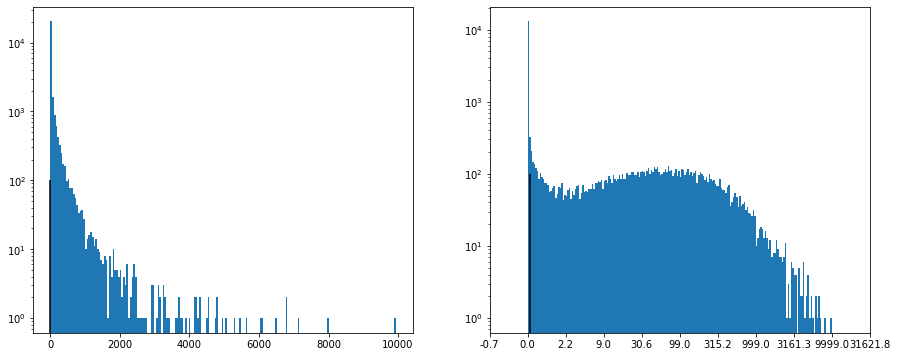

In [211]:
plt.rcParams["figure.figsize"] = (15,6)
ax1 = plt.subplot(1,2,1)
plt.hist(lofar[lofar["lr_w1"] != 0]["lr_w1"], bins=200)
plt.vlines([threshold_w1], 0, 100)
ax1.set_yscale("log", nonposy='clip')
#plt.ylim([0,100])
ax2 = plt.subplot(1,2,2)
plt.hist(np.log10(lofar[lofar["lr_w1"] != 0]["lr_w1"]+1), bins=200)
plt.vlines(np.log10(np.array([threshold_w1])+1), 0, 100)
ticks, _ = plt.xticks()
plt.xticks(ticks, ["{:.1f}".format(10**t-1) for t in ticks])
ax2.set_yscale("log", nonposy='clip')
#plt.ylim([0,100]);

In [213]:
np.sum(lofar["lr_w1"] >= threshold_w1)

12390

In [214]:
lofar["lr_index_sel_w1"] = lofar["lr_index_w1"]
lofar["lr_index_sel_w1"][lofar["lr_w1"] < threshold_w1] = np.nan

Save LR of the W1-band in an external file

In [215]:
columns = ["lr_w1", "lr_dist_w1", "lr_index_w1", "lr_index_sel_w1"]
np.savez_compressed(os.path.join(idp, "lr_w1.npz"), lr_w1=lofar[columns])

### W2-band match

In [216]:
subsample_w2 = (lofar["lr_r"] <= threshold_r) & (lofar["lr_w1"] <= threshold_w1)

#### Compute the W2 $Q_0$

In [217]:
coords_lofar_alt2 = coords_lofar[subsample_w2]

In [218]:
q_0_comp_w2 = Q_0(coords_lofar_alt2, coords_combined[combined_wise2], field)

In [219]:
q_0_rad_w2 = []
q_0_rad_w2_std = []
for radius in rads:
    q_0_rad_aux = []
    for i in range(n_iter):
        out = q_0_comp_w2(radius=radius)
        q_0_rad_aux.append(out)
    q_0_rad_w2.append(np.mean(q_0_rad_aux))
    q_0_rad_w2_std.append(np.std(q_0_rad_aux))
    print(
        "{:2d} {:7.5f} +/- {:7.5f} [{:7.5f} {:7.5f}]".format(
            radius,
            np.mean(q_0_rad_aux),
            np.std(q_0_rad_aux),
            np.min(q_0_rad_aux),
            np.max(q_0_rad_aux),
        )
    )

 1 0.00701 +/- 0.00015 [0.00670 0.00717]
 2 0.01833 +/- 0.00029 [0.01780 0.01873]
 3 0.02626 +/- 0.00027 [0.02581 0.02668]
 4 0.03085 +/- 0.00038 [0.03000 0.03139]
 5 0.03441 +/- 0.00067 [0.03353 0.03568]
 6 0.03565 +/- 0.00068 [0.03460 0.03717]
 7 0.03751 +/- 0.00086 [0.03577 0.03901]
 8 0.04000 +/- 0.00085 [0.03831 0.04145]
 9 0.04206 +/- 0.00082 [0.04084 0.04347]
10 0.04266 +/- 0.00138 [0.04064 0.04478]
11 0.04371 +/- 0.00090 [0.04214 0.04583]
12 0.04463 +/- 0.00113 [0.04254 0.04625]
13 0.04624 +/- 0.00069 [0.04516 0.04773]
14 0.04652 +/- 0.00153 [0.04405 0.04897]
15 0.04810 +/- 0.00183 [0.04514 0.05083]
16 0.04705 +/- 0.00219 [0.04458 0.05139]
17 0.04775 +/- 0.00192 [0.04472 0.05088]
18 0.04728 +/- 0.00225 [0.04396 0.05192]
19 0.05051 +/- 0.00205 [0.04749 0.05483]
20 0.05114 +/- 0.00208 [0.04783 0.05437]
21 0.05417 +/- 0.00210 [0.05064 0.05716]
22 0.05571 +/- 0.00105 [0.05362 0.05733]
23 0.05355 +/- 0.00198 [0.05080 0.05799]
24 0.05732 +/- 0.00252 [0.05219 0.05980]
25 0.05697 +/- 0

In [220]:
q_0_rad_w2 = np.array(q_0_rad_w2)
q_0_rad_w2_std = np.array(q_0_rad_w2_std)

(0, 0.1)

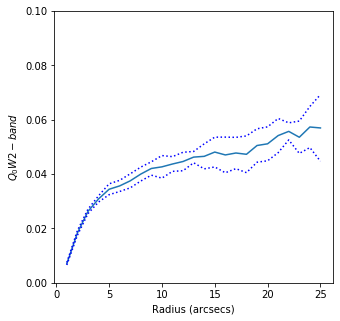

In [222]:
plt.rcParams["figure.figsize"] = (5, 5)
plt.plot(rads, q_0_rad_w2)
plt.plot(rads, q_0_rad_w2 + 3 * q_0_rad_w2_std, ls=":", color="b")
plt.plot(rads, q_0_rad_w2 - 3 * q_0_rad_w2_std, ls=":", color="b")
plt.xlabel("Radius (arcsecs)")
plt.ylabel("$Q_0 W2-band$")
plt.ylim([0, 0.1])

In [223]:
Q0_w2 = q_0_rad_w2[4]

#### Create the likelihood estimator and run

In [224]:
likelihood_ratio_w2 = SingleMLEstimator(Q0_w2, n_m_w2, q_m_w2, center_w2)

In [225]:
idx_lofar, idx_i, d2d, d3d = search_around_sky(
    coords_lofar[subsample_w2], coords_combined[combined_wise2], radius*u.arcsec)

In [226]:
idx_lofar_unique = np.unique(idx_lofar)

In [227]:
lofar["lr_w2"] = np.nan                   # Likelihood ratio
lofar["lr_dist_w2"] = np.nan              # Distance to the selected source
lofar["lr_index_w2"] = np.nan             # Index of the PanSTARRS source in combined

In [228]:
def ml_w2(i):
    idx_0 = idx_i[idx_lofar == i]
    d2d_0 = d2d[idx_lofar == i]
    mag = catalogue_w2["MAG_W2"][idx_0]
    
    lofar_ra = lofar[subsample_w2][i]["RA"]
    lofar_dec = lofar[subsample_w2][i]["DEC"]
    lofar_pa = lofar[subsample_w2][i]["PA"]
    lofar_maj_err = lofar[subsample_w2][i]["E_Maj"]
    lofar_min_err = lofar[subsample_w2][i]["E_Min"]
    c_ra = catalogue_w2["RA"][idx_0]
    c_dec = catalogue_w2["DEC"][idx_0]
    c_ra_err = np.ones_like(c_ra)*0.6/3600.
    c_dec_err = np.ones_like(c_ra)*0.6/3600.
    
    sigma_0_0, det_sigma = get_sigma_all(lofar_maj_err, lofar_min_err, lofar_pa, 
                      lofar_ra, lofar_dec, 
                      c_ra, c_dec, c_ra_err, c_dec_err)
    
    lr_0 = likelihood_ratio_w2(mag, d2d_0.arcsec, sigma_0_0, det_sigma)
    chosen_index = np.argmax(lr_0)
    result = [combined_aux_index[combined_wise2][idx_0[chosen_index]], # Index
              (d2d_0.arcsec)[chosen_index],                        # distance
              lr_0[chosen_index]]                                  # LR
    return result

In [229]:
#res = parallel_process(idx_lofar_unique, ml_w1, n_jobs=n_cpus)
res = Parallel(n_jobs=n_cpus)(delayed(ml_w2)(i) for i in tqdm_notebook(idx_lofar_unique))

In [230]:
indices_w2 = np.arange(len(lofar))[subsample_w2][idx_lofar_unique]

In [231]:
(lofar["lr_index_w2"][indices_w2], 
 lofar["lr_dist_w2"][indices_w2], 
 lofar["lr_w2"][indices_w2]) = list(map(list, zip(*res)))

#### Threshold and selection for W2 band

In [232]:
lofar["lr_w2"][np.isnan(lofar["lr_w2"])] = 0

In [233]:
threshold_w2 = np.percentile(lofar[subsample_w2]["lr_w2"], 100*(1 - Q0_w2))

In [234]:
threshold_w2 # 0.695 before

0.045695339344667234

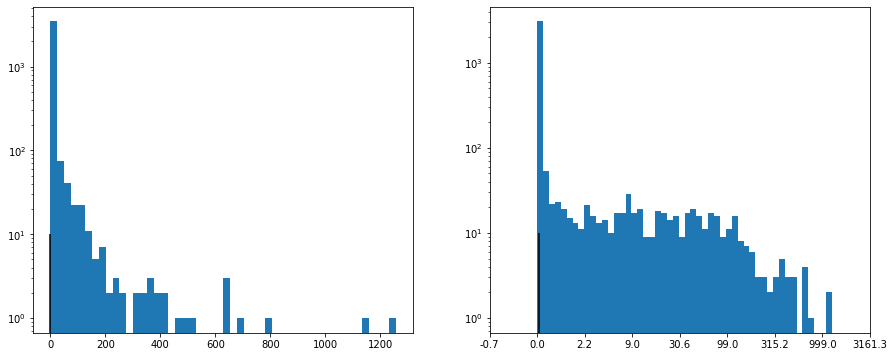

In [235]:
plt.rcParams["figure.figsize"] = (15,6)
ax1 = plt.subplot(1,2,1)
plt.hist(lofar[lofar["lr_w2"] != 0]["lr_w2"], bins=50)
plt.vlines([threshold_w2], 0, 10)
ax1.set_yscale("log", nonposy='clip')
#plt.ylim([0,100])
ax2 = plt.subplot(1,2,2)
plt.hist(np.log10(lofar[lofar["lr_w2"] != 0]["lr_w2"]+1), bins=50)
plt.vlines(np.log10(np.array([threshold_w2])+1), 0, 10)
ticks, _ = plt.xticks()
plt.xticks(ticks, ["{:.1f}".format(10**t-1) for t in ticks])
ax2.set_yscale("log", nonposy='clip')
#plt.ylim([0,100]);

In [236]:
lofar["lr_index_sel_w2"] = lofar["lr_index_w2"]
lofar["lr_index_sel_w2"][lofar["lr_w2"] < threshold_w2] = np.nan

### Final selection of the match

We combine the ML matching done in r-band, W1-band, and W2-band. All the galaxies were the LR is above the selection ratio for the respective band are finally selected.

In [237]:
lr_r_w1_w2 = (
    ~np.isnan(lofar["lr_index_sel_r"]) & 
    ~np.isnan(lofar["lr_index_sel_w1"]) & 
    ~np.isnan(lofar["lr_index_sel_w2"])
)
lr_r_w1 = (
    ~np.isnan(lofar["lr_index_sel_r"]) & 
    ~np.isnan(lofar["lr_index_sel_w1"]) & 
    np.isnan(lofar["lr_index_sel_w2"])
)
lr_r_w2 = (
    ~np.isnan(lofar["lr_index_sel_r"]) & 
    np.isnan(lofar["lr_index_sel_w1"]) & 
    ~np.isnan(lofar["lr_index_sel_w2"])
)
lr_w1_w2 = (
    np.isnan(lofar["lr_index_sel_r"]) & 
    ~np.isnan(lofar["lr_index_sel_w1"]) & 
    ~np.isnan(lofar["lr_index_sel_w2"])
)
lr_r = (
    ~np.isnan(lofar["lr_index_sel_r"]) & 
    np.isnan(lofar["lr_index_sel_w1"]) & 
    np.isnan(lofar["lr_index_sel_w2"])
)
lr_w1 = (
    np.isnan(lofar["lr_index_sel_r"]) & 
    ~np.isnan(lofar["lr_index_sel_w1"]) & 
    np.isnan(lofar["lr_index_sel_w2"])
)
lr_w2 = (
    np.isnan(lofar["lr_index_sel_r"]) & 
    np.isnan(lofar["lr_index_sel_w1"]) & 
    ~np.isnan(lofar["lr_index_sel_w2"])
)
lr_no_match = (
    np.isnan(lofar["lr_index_sel_r"]) & 
    np.isnan(lofar["lr_index_sel_w1"]) & 
    np.isnan(lofar["lr_index_sel_w2"])
)

In [238]:
print(np.sum(lr_r_w1_w2))
print(np.sum(lr_r_w1))
print(np.sum(lr_r_w2))
print(np.sum(lr_w1_w2))
print(np.sum(lr_r))
print(np.sum(lr_w1))
print(np.sum(lr_w2))
print(np.sum(lr_no_match))

0
0
0
0
68853
12390
653
18311


In [240]:
lofar["lr_index_1"] = np.nan
lofar["lr_dist_1"] = np.nan
lofar["lr_1"] = np.nan
lofar["lr_type_1"] = 0

In [241]:
len(lofar)

100207

Enter the data into the table

In [242]:
r_selection = ~np.isnan(lofar["lr_index_sel_r"])
lofar["lr_index_1"][r_selection] = lofar["lr_index_r"][r_selection]
lofar["lr_dist_1"][r_selection] = lofar["lr_dist_r"][r_selection]
lofar["lr_1"][r_selection] = lofar["lr_r"][r_selection]
lofar["lr_type_1"][r_selection] = 1

w1_selection = ~np.isnan(lofar["lr_index_sel_w1"])
lofar["lr_index_1"][w1_selection] = lofar["lr_index_w1"][w1_selection]
lofar["lr_dist_1"][w1_selection] = lofar["lr_dist_w1"][w1_selection]
lofar["lr_1"][w1_selection] = lofar["lr_w1"][w1_selection]
lofar["lr_type_1"][w1_selection] = 2

w2_selection = ~np.isnan(lofar["lr_index_sel_w2"])
lofar["lr_index_1"][w2_selection] = lofar["lr_index_w2"][w2_selection]
lofar["lr_dist_1"][w2_selection] = lofar["lr_dist_w2"][w2_selection]
lofar["lr_1"][w2_selection] = lofar["lr_w2"][w2_selection]
lofar["lr_type_1"][w2_selection] = 3

Summary of the number of sources matched of each type

In [244]:
np.unique(lofar["lr_type_1"], return_counts=True)

(<Column name='lr_type_1' dtype='int64' length=4>
 0
 1
 2
 3, array([18311, 68853, 12390,   653]))

In [246]:
t, c = np.unique(lofar["lr_type_1"], return_counts=True)

In [248]:
for i, t0 in enumerate(t):
    print("Match type {}: {}".format(t0, c[i]))

Match type 0: 18311
Match type 1: 68853
Match type 2: 12390
Match type 3: 653


#### Duplicated sources

This is the nymber of sources of the combined catalogue that are combined to multiple LOFAR sources. In the case of the catalogue of Gaussians the number can be very high.

In [249]:
values, counts = np.unique(lofar[lofar["lr_type_1"] != 0]["lr_index_1"], return_counts=True)

In [250]:
len(values[counts > 1])

101

In [251]:
n_dup, n_sour = np.unique(counts[counts > 1], return_counts=True)

Text(0, 0.5, 'Number of sources in the category')

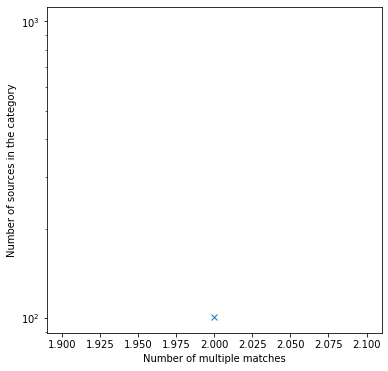

In [252]:
plt.rcParams["figure.figsize"] = (6,6)
plt.semilogy(n_dup, n_sour, marker="x")
plt.xlabel("Number of multiple matches")
plt.ylabel("Number of sources in the category")

### Save intermediate data

In [253]:
if save_intermediate:
    pickle.dump([bin_list_r, center_r, Q0_r, n_m_r, q_m_r], 
                open("{}/lofar_params_1r.pckl".format(idp), 'wb'))
    pickle.dump([bin_list_w1, center_w1, Q0_w1, n_m_w1, q_m_w1], 
                open("{}/lofar_params_1w1.pckl".format(idp), 'wb'))
    pickle.dump([bin_list_w2, center_w2, Q0_w2, n_m_w2, q_m_w2], 
                open("{}/lofar_params_1w2.pckl".format(idp), 'wb'))
    lofar.write("{}/lofar_m1.fits".format(idp), format="fits")

## Second iteration using colour

From now on we will take into account the effect of the colour. The sample was distributed in several categories according to the colour of the source and this is considered here.

### Rusable parameters for all the iterations

These parameters are derived from the underlying population and will not change.

First we compute the number of galaxies in each bin for the combined catalogue

In [254]:
bin_list = [bin_list_w1 if i == 0 else bin_list_r for i in range(len(colour_bin_def))]
centers = [center_w1 if i == 0 else center_r for i in range(len(colour_bin_def))]

In [255]:
numbers_combined_bins = np.array([np.sum(a["condition"]) for a in colour_bin_def])

In [256]:
numbers_combined_bins

array([ 203065, 1516793, 1285276, 1163363, 1419867, 1392164, 1134808,
       1139112, 1392687, 1398193, 1143177, 1322208])

Get the colour category and magnitudes for the matched LOFAR sources

In [257]:
bandwidth_colour = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5]

In [258]:
n_m = []

# W2 only sources
n_m.append(get_n_m_kde(combined["MAG_W2"][combined["category"] == 0], 
                       centers[0], field.area, bandwidth=bandwidth_colour[0]))
# W1 only sources
n_m.append(get_n_m_kde(combined["MAG_W1"][combined["category"] == 1], 
                       centers[1], field.area, bandwidth=bandwidth_colour[1]))

# Rest of the sources
for i in range(2, len(colour_bin_def)):
    n_m.append(get_n_m_kde(combined["MAG_R"][combined["category"] == i], 
                           centers[i], field.area, bandwidth=bandwidth_colour[i]))

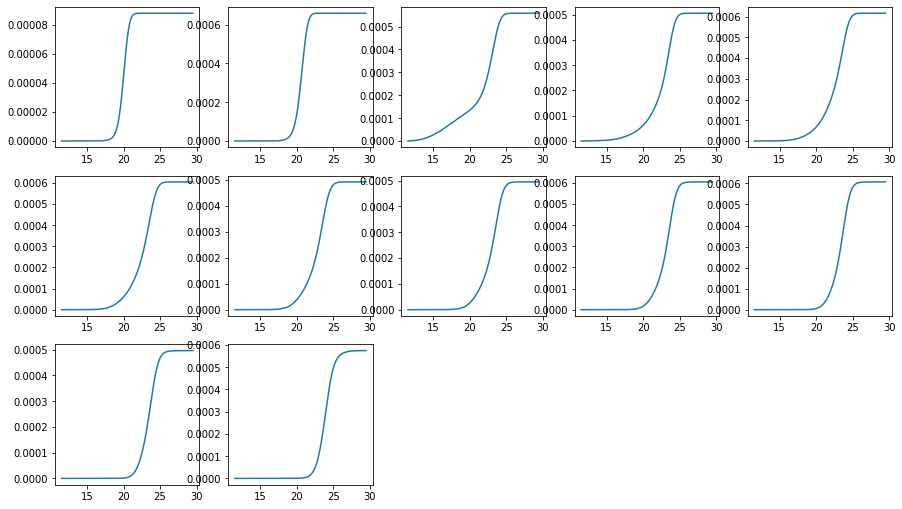

In [259]:
plt.rcParams["figure.figsize"] = (15,15)
for i, n_m_k in enumerate(n_m):
    plt.subplot(5,5,i+1)
    plt.plot(centers[i], np.cumsum(n_m_k))

### Parameters of the matched sample

The parameters derived from the matched LOFAR galaxies: $q_0$, q(m) and the number of sources per category.

The columns "category", "W1mag" and "i" will contain the properties of the matched galaxies and will be updated in each iteration to save space.

In [260]:
lofar["category"] = np.nan
lofar["MAG_W2"] = np.nan
lofar["MAG_W1"] = np.nan
lofar["MAG_R"] = np.nan

In [261]:
c = ~np.isnan(lofar["lr_index_1"])
indices = lofar["lr_index_1"][c].astype(int)
lofar["category"][c] = combined[indices]["category"]
lofar["MAG_W2"][c] = combined[indices]["MAG_W2"]
lofar["MAG_W1"][c] = combined[indices]["MAG_W1"]
lofar["MAG_R"][c] = combined[indices]["MAG_R"]

The next parameter represent the number of matched LOFAR sources in each colour category.

In [262]:
numbers_lofar_combined_bins = np.array([np.sum(lofar["category"] == c) 
                                        for c in range(len(numbers_combined_bins))])

In [263]:
numbers_lofar_combined_bins

array([  653, 12390,   659,   998,  4626,  6821,  5359,  5451,  6937,
        8419, 10183, 19400])

The $Q_0$ for each category are obtained by dividing the number of sources in the category by the total number of sources in the sample.

In [264]:
Q_0_colour = numbers_lofar_combined_bins/len(lofar) ### Q_0

In [265]:
q0_total = np.sum(Q_0_colour)

In [266]:
q0_total

0.8172682547127446

The q(m) is not estimated with the method of Fleuren et al. but with the most updated distributions and numbers for the matches.

In [267]:
q_m = []
radius = 15. 

# W2 only sources
q_m.append(get_q_m_kde(lofar["MAG_W2"][lofar["category"] == 0], 
                   centers[0], 
                   radius=radius,
                   bandwidth=bandwidth_colour[0]))

# W1 only sources
q_m.append(get_q_m_kde(lofar["MAG_W1"][lofar["category"] == 1], 
                   centers[1], 
                   radius=radius,
                   bandwidth=bandwidth_colour[1]))

# Rest of the sources
for i in range(2, len(numbers_lofar_combined_bins)):
    q_m.append(get_q_m_kde(lofar["MAG_R"][lofar["category"] == i], 
                   centers[i], 
                   radius=radius,
                   bandwidth=bandwidth_colour[i]))

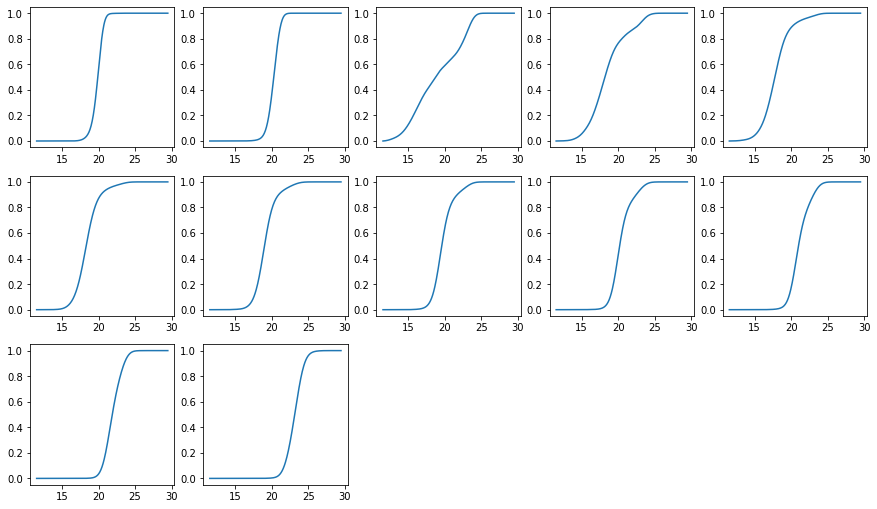

In [268]:
plt.rcParams["figure.figsize"] = (15,15)
for i, q_m_k in enumerate(q_m):
    plt.subplot(5,5,i+1)
    plt.plot(centers[i], np.cumsum(q_m_k))

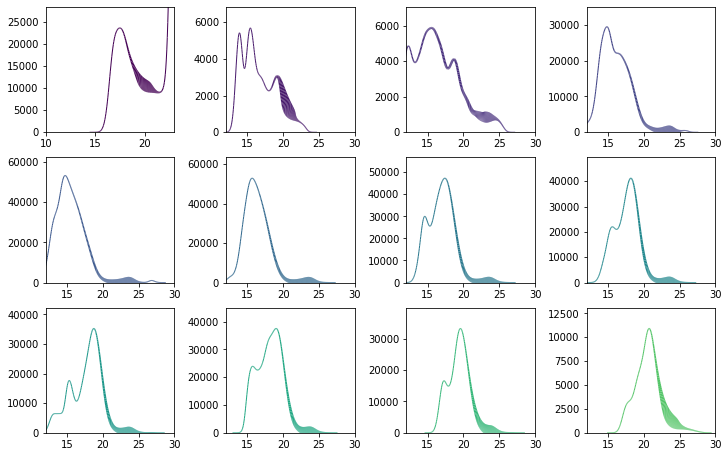

In [269]:
plt.rcParams["figure.figsize"] = (12,10)

from matplotlib import cm
from matplotlib.collections import LineCollection

cm_subsection = np.linspace(0., 1., 16) 
colors = [ cm.viridis(x) for x in cm_subsection ]

low = np.nonzero(centers[1] >= 15)[0][0]
high = np.nonzero(centers[1] >= 22.2)[0][0]

fig, a = plt.subplots()

for i, q_m_k in enumerate(q_m):
    #plot(centers[i], q_m_old[i]/n_m_old[i])
    a = plt.subplot(4,4,i+1)
    if i not in [-1]:
        n_m_aux = n_m[i]/np.sum(n_m[i])
        lwidths = (n_m_aux/np.max(n_m_aux)*10).astype(float) + 1
        #print(lwidths)
        
        y_aux = q_m_k/n_m[i]
        factor = np.max(y_aux[low:high])
        y = y_aux
        #print(y)
        x = centers[i]
        
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        
        lc = LineCollection(segments, linewidths=lwidths, color=colors[i])
        
        a.add_collection(lc)
        
        #plot(centers[i], x/factor, color=colors[i-1])
        plt.xlim([12, 30])
        if i == 0:
            plt.xlim([10, 23])
        plt.ylim([0, 1.2*factor])

plt.subplots_adjust(
    left=0.125, 
    bottom=0.1, 
    right=0.9, 
    top=0.9,
    wspace=0.4, 
    hspace=0.2
)

* https://stackoverflow.com/questions/8931268/using-colormaps-to-set-color-of-line-in-matplotlib
* https://stackoverflow.com/questions/19390895/matplotlib-plot-with-variable-line-width
* https://stackoverflow.com/questions/432112/is-there-a-numpy-function-to-return-the-first-index-of-something-in-an-array

### Save intermediate parameters

In [270]:
if save_intermediate:
    pickle.dump([bin_list, centers, Q_0_colour, n_m, q_m], 
                open("{}/lofar_params_2.pckl".format(idp), 'wb'))

### Prepare for ML

In [271]:
selection = ~np.isnan(combined["category"]) # Avoid the two dreaded sources with no actual data
catalogue = combined[selection]

In [272]:
radius = 15

In [273]:
def apply_ml(i, likelihood_ratio_function):
    idx_0 = idx_i[idx_lofar == i]
    d2d_0 = d2d[idx_lofar == i]
    
    category = catalogue["category"][idx_0].astype(int)
    mag = catalogue["MAG_R"][idx_0]
    mag[category == 0] = catalogue["MAG_W2"][idx_0][category == 0]
    mag[category == 1] = catalogue["MAG_W1"][idx_0][category == 1]
    
    lofar_ra = lofar[i]["RA"]
    lofar_dec = lofar[i]["DEC"]
    lofar_pa = lofar[i]["PA"]
    lofar_maj_err = lofar[i]["E_Maj"]
    lofar_min_err = lofar[i]["E_Min"]
    c_ra = catalogue["RA"][idx_0]
    c_dec = catalogue["DEC"][idx_0]
    c_ra_err = np.ones_like(c_ra)*0.6/3600.
    c_dec_err = np.ones_like(c_ra)*0.6/3600.
    
    sigma_0_0, det_sigma = get_sigma_all(lofar_maj_err, lofar_min_err, lofar_pa, 
                      lofar_ra, lofar_dec, 
                      c_ra, c_dec, c_ra_err, c_dec_err)

    lr_0 = likelihood_ratio_function(mag, d2d_0.arcsec, sigma_0_0, det_sigma, category)
    
    chosen_index = np.argmax(lr_0)
    result = [combined_aux_index[selection][idx_0[chosen_index]], # Index
              (d2d_0.arcsec)[chosen_index],                        # distance
              lr_0[chosen_index]]                                  # LR
    return result

### Run the cross-match

This will not need to be repeated after

In [274]:
idx_lofar, idx_i, d2d, d3d = search_around_sky(
    coords_lofar, coords_combined[selection], radius*u.arcsec)

In [275]:
idx_lofar_unique = np.unique(idx_lofar)

### Run the ML matching

In [276]:
likelihood_ratio = MultiMLEstimator(Q_0_colour, n_m, q_m, centers)

In [277]:
def ml(i):
    return apply_ml(i, likelihood_ratio)

In [ ]:
res = Parallel(n_jobs=n_cpus)(delayed(ml)(i) for i in tqdm_notebook(idx_lofar_unique))

In [279]:
lofar["lr_index_2"] = np.nan
lofar["lr_dist_2"] = np.nan
lofar["lr_2"] = np.nan

In [280]:
(lofar["lr_index_2"][idx_lofar_unique], 
 lofar["lr_dist_2"][idx_lofar_unique], 
 lofar["lr_2"][idx_lofar_unique]) = list(map(list, zip(*res)))

Get the new threshold for the ML matching. FIX THIS

In [281]:
lofar["lr_2"][np.isnan(lofar["lr_2"])] = 0

In [282]:
threshold = np.percentile(lofar["lr_2"], 100*(1 - q0_total))
#manual_q0 = 0.65
#threshold = np.percentile(lofar["lr_2"], 100*(1 - manual_q0))

In [283]:
threshold # Old: 0.69787

0.254664080193482

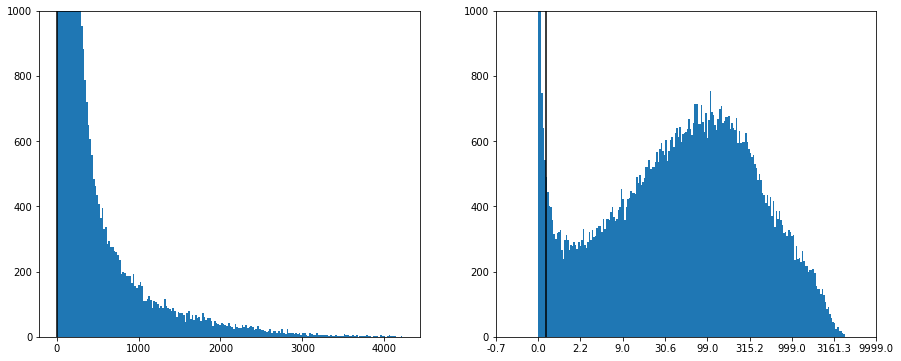

In [284]:
plt.rcParams["figure.figsize"] = (15,6)
plt.subplot(1,2,1)
plt.hist(lofar[lofar["lr_2"] != 0]["lr_2"], bins=200)
plt.vlines([threshold], 0, 1000)
plt.ylim([0,1000])
plt.subplot(1,2,2)
plt.hist(np.log10(lofar[lofar["lr_2"] != 0]["lr_2"]+1), bins=200)
plt.vlines(np.log10(threshold+1), 0, 1000)
ticks, _ = plt.xticks()
plt.xticks(ticks, ["{:.1f}".format(10**t-1) for t in ticks])
plt.ylim([0,1000]);

In [285]:
lofar["lr_index_sel_2"] = lofar["lr_index_2"]
lofar["lr_index_sel_2"][lofar["lr_2"] < threshold] = np.nan

In [286]:
n_changes = np.sum((lofar["lr_index_sel_2"] != lofar["lr_index_1"]) & 
                   ~np.isnan(lofar["lr_index_sel_2"]) &
                   ~np.isnan(lofar["lr_index_1"]))

In [287]:
n_changes # Old: 3135

3135

Enter the results

In [288]:
# Clear aux columns
lofar["category"] = np.nan
lofar["MAG_W2"] = np.nan
lofar["MAG_W1"] = np.nan
lofar["MAG_R"] = np.nan

c = ~np.isnan(lofar["lr_index_sel_2"])
indices = lofar["lr_index_sel_2"][c].astype(int)
lofar["category"][c] = combined[indices]["category"]
lofar["MAG_W2"][c] = combined[indices]["MAG_W2"]
lofar["MAG_W1"][c] = combined[indices]["MAG_W1"]
lofar["MAG_R"][c] = combined[indices]["MAG_R"]

In [289]:
numbers_lofar_combined_bins = np.array([np.sum(lofar["category"] == c) 
                                        for c in range(len(numbers_combined_bins))])

In [290]:
numbers_lofar_combined_bins

array([  736, 12494,   252,   681,  4348,  6526,  5116,  5223,  6702,
        8298, 10410, 21110])

### Save intermediate data

In [291]:
if save_intermediate:
    lofar.write("{}/lofar_m2.fits".format(idp), format="fits")

## Iterate until convergence

In [292]:
rerun_iter = False

In [293]:
if rerun_iter:
    lofar = Table.read("{}/lofar_m2.fits".format(idp))
    bin_list, centers, Q_0_colour, n_m, q_m = pickle.load(open("{}/lofar_params_2.pckl".format(idp), 'rb'))
    inter_data_list = glob("{}/lofar_m*.fits".format(idp))
    # Remove data
    for inter_data_file in inter_data_list:
        if inter_data_file[-7:-5] not in ["m1", "m2"]:
            #print(inter_data_file)
            os.remove(inter_data_file)
    # Remove images
    images_list = glob("{}/*.png".format(idp))
    for images in images_list:
        #print(images)
        os.remove(images)
    # Remove parameters
    inter_param_list = glob("{}/lofar_params_*.pckl".format(idp))
    for inter_param_file in inter_param_list:
        if inter_param_file[-7:-5] not in ["1i", "w1", "_2"]:
            #print(inter_param_file)
            os.remove(inter_param_file)

In [294]:
radius = 15. 

In [295]:
from matplotlib import pyplot as plt

In [300]:
def plot_q_n_m(q_m, n_m):
    fig, a = plt.subplots()

    for i, q_m_k in enumerate(q_m):
        #plot(centers[i], q_m_old[i]/n_m_old[i])
        a = plt.subplot(4,4,i+1)
        if i not in [-1]:
            n_m_aux = n_m[i]/np.sum(n_m[i])
            lwidths = (n_m_aux/np.max(n_m_aux)*10).astype(float) + 1
            #print(lwidths)

            y_aux = q_m_k/n_m[i]
            factor = np.max(y_aux[low:high])
            y = y_aux
            #print(y)
            x = centers[i]

            points = np.array([x, y]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)

            lc = LineCollection(segments, linewidths=lwidths, color=colors[i])

            a.add_collection(lc)

            #plot(centers[i], x/factor, color=colors[i-1])
            plt.xlim([12, 30])
            if i == 0:
                plt.xlim([10, 23])
            plt.ylim([0, 1.2*factor])

    plt.subplots_adjust(left=0.125, 
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9,
                    wspace=0.4, 
                    hspace=0.2)
    return fig

In [ ]:
for j in range(10):
    iteration = j+3 
    print("Iteration {}".format(iteration))
    print("=============")
    ## Get new parameters
    # Number of matched sources per bin
    numbers_lofar_combined_bins = np.array([np.sum(lofar["category"] == c) 
                                            for c in range(len(numbers_combined_bins))])
    print("numbers_lofar_combined_bins")
    print(numbers_lofar_combined_bins)
    # q_0
    Q_0_colour_est = numbers_lofar_combined_bins/len(lofar) ### Q_0
    Q_0_colour = q0_min_level(Q_0_colour_est, min_level=0.001)
    print("Q_0_colour")
    print(Q_0_colour)
    q0_total = np.sum(Q_0_colour)
    print("Q_0_total: ", q0_total)
    # q_m
    q_m = []
    # W2 only sources
    q_m.append(get_q_m_kde(lofar["MAG_W2"][lofar["category"] == 0], 
                       centers[0], 
                       radius=radius,
                       bandwidth=bandwidth_colour[0]))
    # W1 only sources
    q_m.append(get_q_m_kde(lofar["MAG_W1"][lofar["category"] == 1], 
                       centers[1], 
                       radius=radius,
                       bandwidth=bandwidth_colour[1]))
    # Rest of the sources
    for i in range(2, len(numbers_lofar_combined_bins)):
        q_m.append(get_q_m_kde(lofar["MAG_R"][lofar["category"] == i], 
                       centers[i], 
                       radius=radius,
                       bandwidth=bandwidth_colour[i]))
    # Save new parameters
    if save_intermediate:
        pickle.dump([bin_list, centers, Q_0_colour, n_m, q_m], 
                    open("{}/lofar_params_{}.pckl".format(idp, iteration), 'wb'))
    if plot_intermediate:
        fig = plt.figure(figsize=(15,15))
        for i, q_m_k in enumerate(q_m):
            plt.subplot(5,5,i+1)
            plt.plot(centers[i], q_m_k)
        plt.savefig('{}/q0_{}.png'.format(idp, iteration))
        del fig
        fig = plt.figure(figsize=(15,15))
        for i, q_m_k in enumerate(q_m):
            plt.subplot(5,5,i+1)
            plt.plot(centers[i], q_m_k/n_m[i])
        plt.savefig('{}/q_over_n_{}.png'.format(idp, iteration))
        del fig
        fig = plot_q_n_m(q_m, n_m)
        plt.savefig('{}/q_over_n_nice_{}.png'.format(idp, iteration))
        del fig
    ## Define new likelihood_ratio
    likelihood_ratio = MultiMLEstimator(Q_0_colour, n_m, q_m, centers)
    def ml(i):
        return apply_ml(i, likelihood_ratio)
    ## Run the ML
    #res = parallel_process(idx_lofar_unique, ml, n_jobs=n_cpus)
    res = Parallel(n_jobs=n_cpus)(delayed(ml)(i) for i in tqdm_notebook(idx_lofar_unique))
    lofar["lr_index_{}".format(iteration)] = np.nan
    lofar["lr_dist_{}".format(iteration)] = np.nan
    lofar["lr_{}".format(iteration)] = np.nan
    (lofar["lr_index_{}".format(iteration)][idx_lofar_unique], 
     lofar["lr_dist_{}".format(iteration)][idx_lofar_unique], 
     lofar["lr_{}".format(iteration)][idx_lofar_unique]) = list(map(list, zip(*res)))
    lofar["lr_{}".format(iteration)][np.isnan(lofar["lr_{}".format(iteration)])] = 0
    ## Get and apply the threshold
    threshold = np.percentile(lofar["lr_{}".format(iteration)], 100*(1 - q0_total))
    #threshold = get_threshold(lofar[lofar["lr_{}".format(iteration)] != 0]["lr_{}".format(iteration)])
    print("Threshold: ", threshold)
    if plot_intermediate:
        fig = plt.figure(figsize=(15,6))
        plt.subplot(1,2,1)
        plt.hist(lofar[lofar["lr_{}".format(iteration)] != 0]["lr_{}".format(iteration)], bins=200)
        plt.vlines([threshold], 0, 1000)
        plt.ylim([0,1000])
        plt.subplot(1,2,2)
        plt.hist(np.log10(lofar[lofar["lr_{}".format(iteration)] != 0]["lr_{}".format(iteration)]+1), bins=200)
        plt.vlines(np.log10(threshold+1), 0, 1000)
        ticks, _ = plt.xticks()
        plt.xticks(ticks, ["{:.1f}".format(10**t-1) for t in ticks])
        plt.ylim([0,1000])
        plt.savefig('{}/lr_distribution_{}.png'.format(idp, iteration))
        del fig
    ## Apply the threshold
    lofar["lr_index_sel_{}".format(iteration)] = lofar["lr_index_{}".format(iteration)]
    lofar["lr_index_sel_{}".format(iteration)][lofar["lr_{}".format(iteration)] < threshold] = np.nan
    ## Enter changes into the catalogue
    # Clear aux columns
    lofar["category"] = np.nan
    lofar["MAG_W2"] = np.nan
    lofar["MAG_W1"] = np.nan
    lofar["MAG_R"] = np.nan
    # Update data
    c = ~np.isnan(lofar["lr_index_sel_{}".format(iteration)])
    indices = lofar["lr_index_sel_{}".format(iteration)][c].astype(int)
    lofar["category"][c] = combined[indices]["category"]
    lofar["MAG_W2"][c] = combined[indices]["MAG_W2"]
    lofar["MAG_W1"][c] = combined[indices]["MAG_W1"]
    lofar["MAG_R"][c] = combined[indices]["MAG_R"]
    # Save the data
    if save_intermediate:
        lofar.write("{}/lofar_m{}.fits".format(idp, iteration), format="fits")
    ## Compute number of changes
    n_changes = np.sum((
            lofar["lr_index_sel_{}".format(iteration)] != lofar["lr_index_sel_{}".format(iteration-1)]) & 
            ~np.isnan(lofar["lr_index_sel_{}".format(iteration)]) &
            ~np.isnan(lofar["lr_index_sel_{}".format(iteration-1)]))
    print("N changes: ", n_changes)
    t_changes = np.sum((
            lofar["lr_index_sel_{}".format(iteration)] != lofar["lr_index_sel_{}".format(iteration-1)]))
    print("T changes: ", t_changes)
    ## Check changes
    if n_changes == 0:
        break
    else:
        print("******** continue **********")

Iteration 3
numbers_lofar_combined_bins
[  736 12494   252   681  4348  6526  5116  5223  6702  8298 10410 21110]
Q_0_colour
[0.0073448  0.12468191 0.00251479 0.00679593 0.04339018 0.06512519
 0.05105432 0.05212211 0.06688156 0.08280859 0.10388496 0.21066393]
Q_0_total:  0.8172682547127446


In [164]:
numbers_lofar_combined_bins = np.array([np.sum(lofar["category"] == c) 
                                        for c in range(len(numbers_combined_bins))])
numbers_lofar_combined_bins

array([19588,  3729,    83,   518,  2295,  3282,  4700,  5248,  5054,
        4569,  4370,  3851,  3313,  4410,  1679,   540])

In [165]:
if save_intermediate:
    pickle.dump([numbers_lofar_combined_bins, numbers_combined_bins], 
                open("{}/numbers_{}.pckl".format(idp, iteration), 'wb'))

In [167]:
good = False

In [193]:
if good:
    if os.path.exists("lofar_params.pckl"):
        os.remove("lofar_params.pckl")
    copyfile("{}/lofar_params_{}.pckl".format(idp, iteration), "lofar_params.pckl")